In [98]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
from tqdm import tqdm
from kan import KAN, KANLayer
import torch.optim as optim
from kan import *
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [217]:
# 1. Load and preprocess UCI Heart Disease dataset
path = "Data/heart.dat"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(path, sep=' ', header=None, names=column_names)
X = df.drop('target', axis=1).values
y = (df['target'] - 1).values  # Convert to 0/1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# dtype = torch.get_default_dtype()
# dataset = {}
# dataset['train_input'] = X_train_tensor.to(device)
# dataset['test_input'] = X_test_tensor.to(device)
# dataset['train_label'] = y_train_tensor.to(device)
# dataset['test_label'] = y_test_tensor.to(device)

In [256]:
class kan_model(nn.Module):
    def __init__(self,width):
        super(kan_model, self).__init__()
        self.KAN = KAN(width=width, grid=5, k=3)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        output = self.KAN(x)
        output = self.sig(output)
        return output

my_kan = kan_model(width = [13,1]).to(device)
optimizer_kan = optim.Adam(my_kan.parameters(), lr=1e-3)

checkpoint directory created: ./model
saving model version 0.0


In [257]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [258]:
mlp = MLP(13, [9]).to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
loss_fun = nn.BCELoss()
num_epochs = 200


In [259]:
def train(model, num_epochs, train_dl, x_test,y_test,loss_fn,optimizer):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch,y_batch in train_dl:        
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)
        model.eval()
        with torch.no_grad():
            pred = model(x_test)
            loss = loss_fn(pred, y_test)
            loss_hist_valid[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_test).float()
            accuracy_hist_valid[epoch] += is_correct.mean()
        if epoch%50==49: 
            print(f'Epoch {epoch+1} accuracy: 'f'{accuracy_hist_train[epoch]:.4f}, val_accuracy: 'f'{accuracy_hist_valid[epoch]:.4f}, loss: 'f'{loss_hist_train[epoch]:.4f}, val_loss: 'f'{loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid,accuracy_hist_train, accuracy_hist_valid


In [260]:
history_mlp = train(mlp, num_epochs, train_loader, X_test_tensor, y_test_tensor,loss_fun,optimizer)

Epoch 50 accuracy: 0.8472, val_accuracy: 0.8519, loss: 0.3477, val_loss: 0.3922
Epoch 100 accuracy: 0.8657, val_accuracy: 0.8519, loss: 0.2879, val_loss: 0.4382
Epoch 150 accuracy: 0.8657, val_accuracy: 0.8333, loss: 0.2609, val_loss: 0.4887
Epoch 200 accuracy: 0.8796, val_accuracy: 0.8519, loss: 0.2422, val_loss: 0.5346


Text(0.5, 0, 'Epochs')

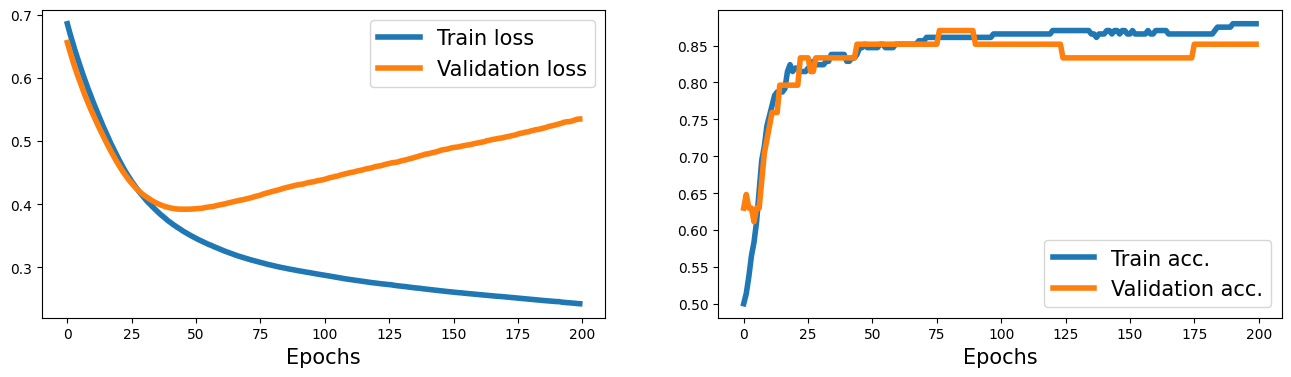

In [261]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history_mlp[0], lw=4)
plt.plot(history_mlp[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history_mlp[2], lw=4)
plt.plot(history_mlp[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [262]:
history_kan = train(my_kan, num_epochs, train_loader, X_test_tensor, y_test_tensor,loss_fun,optimizer_kan)

Epoch 50 accuracy: 0.8704, val_accuracy: 0.8333, loss: 0.3808, val_loss: 0.4173
Epoch 100 accuracy: 0.8704, val_accuracy: 0.7963, loss: 0.3070, val_loss: 0.3901
Epoch 150 accuracy: 0.8843, val_accuracy: 0.8148, loss: 0.2791, val_loss: 0.4000
Epoch 200 accuracy: 0.8935, val_accuracy: 0.8333, loss: 0.2608, val_loss: 0.4177


Text(0.5, 0, 'Epochs')

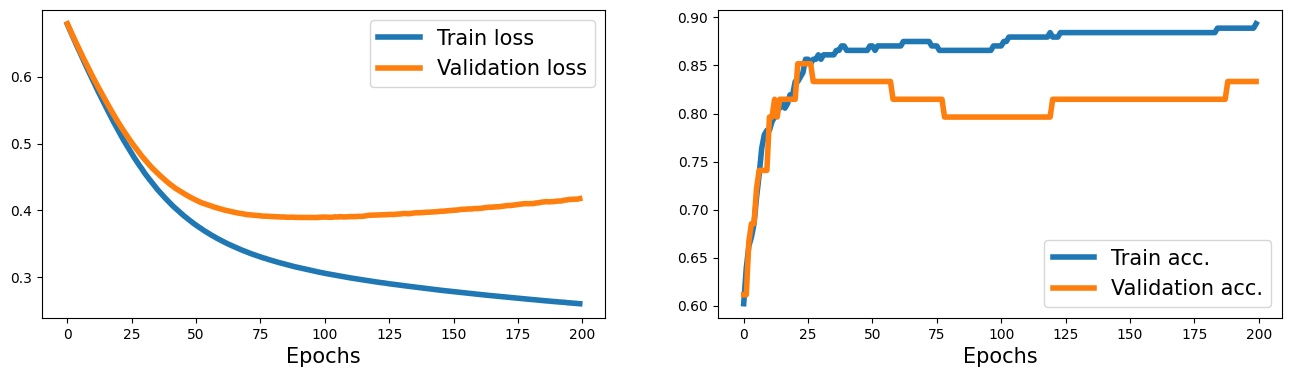

In [263]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history_kan[0], lw=4)
plt.plot(history_kan[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history_kan[2], lw=4)
plt.plot(history_kan[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [241]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# For MLP:
mlp_param_count = count_trainable_params(mlp)
print(f"MLP trainable parameters: {mlp_param_count}")

# For KAN:
kan_param_count = count_trainable_params(my_kan)
print(f"KAN trainable parameters: {kan_param_count}")

MLP trainable parameters: 241
KAN trainable parameters: 392


In [ ]:
mlp.eval()
with torch.no_grad():
    mlp_pred = ((mlp(X_test_tensor.to(device)).detach().cpu())>=0.5).float()
    kan_pred = ((my_kan(X_test_tensor.to(device)).detach().cpu())>=0.5).float()

In [242]:
# Function to compute all regression metrics
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return {
        'ACC': acc,
        'Prec': prec,
        'Rec': rec,
        'F1' : f1,
        'AUC': auc
    }


In [244]:
# Compute metrics
kan_metrics = compute_metrics(y_test_tensor, kan_pred)
mlp_metrics = compute_metrics(y_test_tensor, mlp_pred)

In [246]:
mlp_metrics

{'ACC': 0.8148148148148148,
 'Prec': np.float64(0.75),
 'Rec': np.float64(0.875),
 'F1': np.float64(0.8076923076923077),
 'AUC': np.float64(0.8208333333333333)}

In [247]:
kan_metrics

{'ACC': 0.5,
 'Prec': np.float64(0.46511627906976744),
 'Rec': np.float64(0.8333333333333334),
 'F1': np.float64(0.5970149253731343),
 'AUC': np.float64(0.5333333333333333)}